In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import optuna
import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize

Data preprocessing

In [2]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru").to('cuda')
dataset = pd.read_excel(r"C:\Users\shari\siriushack\sentences.xlsx")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

new_data = {i: [] for i in dataset.columns}
for i in tqdm(range(dataset.shape[1])):
    col_embs = []
    for j in tqdm(range(dataset.shape[0])):
        elem = dataset.iloc[j][i]
        if pd.isna(elem):
            continue

        for sent in elem.split('.'):
            sent = sent.strip()
            if sent and len(sent) > 3 and any(c.isalpha() for c in sent):
                col_embs.append(sent.lower())
    new_data[dataset.columns[i]] = col_embs

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

In [3]:
new_data['Комментарий к вопросу  1. Какие причины (факторы) сформировали ваше решение уйти из компании (выберите не более 3-х).']

['в связи с переездом в другой регион',
 'жизненные трудности поспособствовали моему увольнению, так как нужно идти на другую работу',
 'тест',
 'руководство регулярно манипулирует, газлайтит (виноват всегда и во всем сотрудник и ты начинаешь верить, что ты бездарь), токсичное отношение к сотрудникам',
 'похвалили, сказали, что переведут на другую должность+оклад поднимут почти в 2 раза, по факту обвинили в том, что что-то не было сделано (хотя задач таких никто не ставил)',
 'посыл: работай больше, ты и так не справляешься, поднимать зп не будем',
 'разброс зп в отделе от 130 тыс',
 'до 60!!! как можно платить сотруднику 60 тыс',
 'в москве?!',
 'мой карьерный рост слишком сильно отстал по отношению к тому функционалу и той ответственности, которые я на себя брал',
 'многие мои коллеги из цатэ, обладая гораздо меньшим опытом, оказались на несколько должностей выше меня',
 'как результат, после очередного выгорания на рабочем месте, мною был запущен мониторинг рынка труда, который пока

In [4]:
len(new_data['Комментарий к вопросу  1. Какие причины (факторы) сформировали ваше решение уйти из компании (выберите не более 3-х).'])

1067

In [5]:
emb_dict = {i: [] for i in dataset.columns}
batch_size = 16
for column in tqdm(dataset.columns):
    for start in tqdm(range(0, len(new_data[column]), batch_size)):
        end = min(start + batch_size, len(new_data[column]))
        batch_data = new_data[column][start:end]
        encoded_data = tokenizer(batch_data, padding=True, truncation=True, max_length=32, return_tensors='pt').to('cuda')
        
        with torch.no_grad():
            output = model(**encoded_data)

        embeddings = mean_pooling(output, encoded_data['attention_mask']).cpu().numpy()

        emb_dict[column].extend(embeddings.tolist())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

c:\Users\shari\anaconda3\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [6]:
embeddings = emb_dict['Комментарий к вопросу  1. Какие причины (факторы) сформировали ваше решение уйти из компании (выберите не более 3-х).']

In [7]:
arr1 = new_data['Комментарий к вопросу  1. Какие причины (факторы) сформировали ваше решение уйти из компании (выберите не более 3-х).']
arr2 = emb_dict['Комментарий к вопросу  1. Какие причины (факторы) сформировали ваше решение уйти из компании (выберите не более 3-х).']

In [8]:
ban = ['росатом', 'гринатом', 'ао', 'зао', 'пао', 'росэнергоатом', 'лихачев', 'лихачёв']
for i in range(len(arr1)):
    for word in ban:
        if word in arr1[i].lower():
            print(arr1[i])
            arr1[i] = arr1[i].replace(word, 'компания')

и ёщё укажу своё субъективное мнение - я считаю, что учебный процесс по этому направлению (sap bi) организован не так, чтобы помочь стажеру легче и проще разобраться, а наоборот, но это моё личное мнение, так как, как я понимаю, многие из группы, в которой я училась, успешно завершили стажировку и будут продолжать работать по этому направлению, возможно, такая организация учебного процесса позволяет отобрать людей, которым очень подходит это направление, но мне кажется, что при другой организации учебного процесса больше стажеров могли бы остаться работать после окончания стажировки, так как работу найти непросто, поэтому критерий выбора наиболее интересного направления, он не является главным при поиске работы (я имею ввиду, что если бы у меня получилось успешно пройти стажировку, я бы осталась работать в гринатоме, несмотря на то, что меня больше интересуют другие направления в области информационных технологий)
и ёщё укажу своё субъективное мнение - я считаю, что учебный процесс по 

EUCLIDIAN METRIC (As a baseline example, without hyperparameters tuning)

In [9]:
labels = KMeans(random_state=42, n_clusters=15).fit(np.array(embeddings)).labels_
clusters_sentences = {}

for i in range(len(arr1)):
    cluster_id = labels[i]
    if cluster_id not in clusters_sentences:
        clusters_sentences[cluster_id] = []
    clusters_sentences[cluster_id].append((arr1[i], arr2[i]))

representative_sentences = {}
top_clusters = sorted(clusters_sentences.keys(), key = lambda x : len(clusters_sentences[x]), reverse=True)[:10]


def find_closest_vector_to_mean(cluster_vectors):
    # Вычисляем средний вектор
    mean_vector = np.mean(cluster_vectors, axis=0)

    # Вычисляем косинусные расстояния
    distances = cosine_distances(cluster_vectors, mean_vector.reshape(1, -1))

    # Находим индекс вектора с минимальным расстоянием
    closest_index = np.argmin(distances)

    # Возвращаем ближайший вектор и его расстояние
    return closest_index, distances[closest_index][0]

final_dict = {}
for cluster in top_clusters:
    array = clusters_sentences[cluster]
    embs = np.array([array[i][1] for i in range(len(array))])
    indx, _ = find_closest_vector_to_mean(embs)
    print(f"Cluster {cluster}:{array[indx][0]}")
    final_dict[array[indx][0]] = len(clusters_sentences[cluster])


Cluster 5:конфликтные отношения в коллективе; несогласие со стилем руководства
Cluster 7:я был заинтересован и мотивирован продолжать работу на предприятии, осуществляя карьерный рост и приобретая новые умения и навыки, однако, столкнувшись с безграмотностью и безобразным отношением руководства, а также с продолжением обучения по специальности, я выужден покинуть своё нынешнее место работы
Cluster 11:отсутствие компетентных профессионалов  для новых бизнесов и желание сохранить собственный саботирующий персонал - это катастрофа
Cluster 2:уровень заработной платы не соответствует росту цен
Cluster 13:система повышений устроена весьма некорректно
Cluster 1:отсутствие отлаженных бизнес-процессов при работе на должности
Cluster 6:мне предложили работу по моему предыдущему профилю работы
Cluster 8:большой объем поручаемой работы  на одого специалиста который чисто физически невозможно выполнять, количество сотрудников в отделе не соответствует нагрузке на отдел
Cluster 3:сокращение штата
Cl

COSINE SIMILARITY (As a baseline example, without hyperparameter tuning)

In [10]:
data = embeddings.copy()
normalized_data = normalize(data)
kmeans = KMeans(n_clusters=35, random_state=0).fit(normalized_data)
labels = kmeans.labels_


In [11]:
clusters_sentences = {}

for i in range(len(arr1)):
    cluster_id = labels[i]
    if cluster_id not in clusters_sentences:
        clusters_sentences[cluster_id] = []
    clusters_sentences[cluster_id].append((arr1[i], arr2[i]))

representative_sentences = {}
top_clusters = sorted(clusters_sentences.keys(), key = lambda x : len(clusters_sentences[x]), reverse=True)[:10]  # Get the top 10 cluster IDs

puke = []
for cluster in top_clusters:
    array = clusters_sentences[cluster]
    embs = np.array([array[i][1] for i in range(len(array))])
    indx, _ = find_closest_vector_to_mean(embs)
    print(f"Cluster {cluster}:{array[indx][0]}")
    puke.append(array[indx][0])



Cluster 19:отсутствие отлаженных бизнес-процессов при работе на должности
Cluster 4:процесс взаимодействия внутри компании и отрасли выстроен так, что основная цель большинства закрыть работы/вопросы своего подразделения, а не решить общую проблему для достижения целей работы организации
Cluster 23:я обучаюсь на профессию горный инженер, в дальнейшем мог бы работать в других филиалах компанияа связанных с этой деятельностью
Cluster 34:я был заинтересован и мотивирован продолжать работу на предприятии, осуществляя карьерный рост и приобретая новые умения и навыки, однако, столкнувшись с безграмотностью и безобразным отношением руководства, а также с продолжением обучения по специальности, я выужден покинуть своё нынешнее место работы
Cluster 28:руководство не ценит компетентных сотрудников, должности, зарплаты, график работы распределяются по принципу дружу/не дружу, обесценивают сотрудников и их труд
Cluster 26:конфликтные отношения в коллективе; несогласие со стилем руководства
Cluste

Some researches using optuna lib

Let's define our models we are going to research

In [13]:
embeddings = normalize(embeddings)

In [22]:
from sklearn.cluster import KMeans
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice, plot_contour
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

KMeans research based on silhouette score \
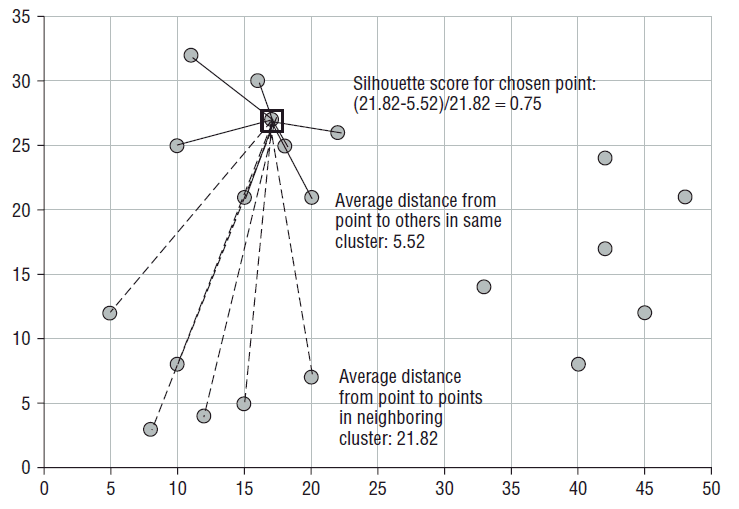

Преимущества KMeans:

прост в реализации и понимании;

наличие большого числа модификаций;

высокая скорость работы и точность на данных сферической формы.

Недостатки KMeans:

низкая точность на данных с несферической формой кластеров;

чувствительность к начальным значениям центроидов и выбросам;

необходимость заранее устанавливать число кластеров, что может быть сложно или не оптимально.

In [32]:
def objective(trial):
    try:
        n_clusters = trial.suggest_int('n_clusters', 10, 30)
        init = trial.suggest_categorical('init', ['k-means++', 'random'])
        algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])
        max_iter = trial.suggest_int('max_iter', 10, 2000)
        tol = trial.suggest_float('tol', 1e-7, 1e-1, log=True)
        random_state = trial.suggest_int('random_state', 0, 100)
        
        kmeans = KMeans(n_clusters=n_clusters, init=init, algorithm=algorithm, 
                       max_iter=max_iter, tol=tol, random_state=random_state)
        kmeans.fit(embeddings)
        labels = kmeans.labels_

        score = silhouette_score(embeddings, labels, metric='euclidean')
        return score
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')

In [33]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=300)
print("Best Hyperparameters:", study.best_params)

[I 2024-11-02 21:27:03,990] A new study created in memory with name: no-name-7d192215-a541-45fa-a826-8d82b2a4acaa
[I 2024-11-02 21:27:04,221] Trial 0 finished with value: 0.038620351817863136 and parameters: {'n_clusters': 25, 'init': 'k-means++', 'algorithm': 'elkan', 'max_iter': 154, 'tol': 2.5676606849133557e-06, 'random_state': 66}. Best is trial 0 with value: 0.038620351817863136.
[I 2024-11-02 21:27:04,419] Trial 1 finished with value: 0.04079449058226165 and parameters: {'n_clusters': 23, 'init': 'k-means++', 'algorithm': 'lloyd', 'max_iter': 1855, 'tol': 0.02763879913130463, 'random_state': 81}. Best is trial 1 with value: 0.04079449058226165.
[I 2024-11-02 21:27:05,007] Trial 2 finished with value: 0.04010202327623676 and parameters: {'n_clusters': 23, 'init': 'random', 'algorithm': 'elkan', 'max_iter': 329, 'tol': 4.9269316850418755e-06, 'random_state': 70}. Best is trial 1 with value: 0.04079449058226165.
[I 2024-11-02 21:27:05,692] Trial 3 finished with value: 0.03185390757

Best Hyperparameters: {'n_clusters': 20, 'init': 'random', 'algorithm': 'elkan', 'max_iter': 1986, 'tol': 4.241051916867869e-06, 'random_state': 14}


In [34]:
plot_param_importances(study)

In [35]:
plot_slice(study)

In [36]:
kmeans = KMeans(**study.best_params).fit(embeddings)
labels = kmeans.labels_

In [37]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(np.array(arr2))

df = pd.DataFrame({
    'tsne_1': tsne_embeddings[:, 0],
    'tsne_2': tsne_embeddings[:, 1],
    'cluster': labels,
    'text': arr1 
})

fig = px.scatter(
    df,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_data=['text'],
    title='t-SNE visualization of text clusters',
    labels={'cluster': 'Cluster'},
    color_continuous_scale='viridis'
)

fig.update_traces(
    marker=dict(size=8),
    selector=dict(mode='markers')
)

fig.update_layout(
    height=800,
    width=1000,
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

fig.write_html("tsne_visualization_kmeans.html")


Let's try KMeans based on Calinski-Harabasz Index
https://www.geeksforgeeks.org/clustering-metrics/#calinskiharabasz-index-variance-ratio-criterion

In [40]:
def objective(trial):
    try:
        n_clusters = trial.suggest_int('n_clusters', 15, 50)
        init = trial.suggest_categorical('init', ['k-means++', 'random'])
        algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])
        max_iter = trial.suggest_int('max_iter', 10, 2000)
        tol = trial.suggest_float('tol', 1e-7, 1e-1, log=True)
        random_state = trial.suggest_int('random_state', 0, 100)
        
        kmeans = KMeans(n_clusters=n_clusters, init=init, algorithm=algorithm, 
                       max_iter=max_iter, tol=tol, random_state=random_state)
        kmeans.fit(embeddings)
        labels = kmeans.labels_

        score = calinski_harabasz_score(embeddings, labels)
        return score
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')

In [41]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=200)
print("Best Hyperparameters:", study.best_params)

[I 2024-11-02 21:33:06,044] A new study created in memory with name: no-name-956c8e7e-0504-40a6-ba1f-13b71de0ee43
[I 2024-11-02 21:33:06,252] Trial 0 finished with value: 12.62547829214342 and parameters: {'n_clusters': 44, 'init': 'k-means++', 'algorithm': 'elkan', 'max_iter': 1277, 'tol': 0.07467381379342462, 'random_state': 4}. Best is trial 0 with value: 12.62547829214342.
[I 2024-11-02 21:33:06,887] Trial 1 finished with value: 22.255982788052595 and parameters: {'n_clusters': 18, 'init': 'random', 'algorithm': 'lloyd', 'max_iter': 915, 'tol': 0.00015546278971548616, 'random_state': 93}. Best is trial 1 with value: 22.255982788052595.
[I 2024-11-02 21:33:07,687] Trial 2 finished with value: 15.755220525689186 and parameters: {'n_clusters': 31, 'init': 'random', 'algorithm': 'lloyd', 'max_iter': 603, 'tol': 0.0006925956063373246, 'random_state': 58}. Best is trial 1 with value: 22.255982788052595.
[I 2024-11-02 21:33:07,911] Trial 3 finished with value: 11.201196162209046 and param

Best Hyperparameters: {'n_clusters': 15, 'init': 'random', 'algorithm': 'elkan', 'max_iter': 1434, 'tol': 2.2805297697546626e-05, 'random_state': 48}


In [42]:
plot_param_importances(study)

In [43]:
plot_slice(study)

In [44]:
kmeans = KMeans(**study.best_params).fit(embeddings)
labels = kmeans.labels_
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(np.array(arr2))

df = pd.DataFrame({
    'tsne_1': tsne_embeddings[:, 0],
    'tsne_2': tsne_embeddings[:, 1],
    'cluster': labels,
    'text': arr1 
})

fig = px.scatter(
    df,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_data=['text'],
    title='t-SNE visualization of text clusters',
    labels={'cluster': 'Cluster'},
    color_continuous_scale='viridis'
)

fig.update_traces(
    marker=dict(size=8),
    selector=dict(mode='markers')
)

fig.update_layout(
    height=800,
    width=1000,
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

fig.write_html("tsne_visualization_kmeans_calinski_harabasz.html")


The result seems to be worse than silhouette score

Let's try clustering based on Davies-Bouldin Index https://www.geeksforgeeks.org/clustering-metrics/

In [45]:
def objective(trial):
    try:
        n_clusters = trial.suggest_int('n_clusters', 10, 40)
        init = trial.suggest_categorical('init', ['k-means++', 'random'])
        algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])
        max_iter = trial.suggest_int('max_iter', 10, 2000)
        tol = trial.suggest_float('tol', 1e-7, 1e-1, log=True)
        random_state = trial.suggest_int('random_state', 0, 100)
        
        kmeans = KMeans(n_clusters=n_clusters, init=init, algorithm=algorithm, 
                       max_iter=max_iter, tol=tol, random_state=random_state)
        kmeans.fit(embeddings)
        labels = kmeans.labels_

        score = davies_bouldin_score(embeddings, labels)
        return score
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('+inf')

In [46]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=200)
print("Best Hyperparameters:", study.best_params)

[I 2024-11-02 21:36:35,025] A new study created in memory with name: no-name-bf5f71c0-317a-4a06-a1b7-5f3f9af3d7e7
[I 2024-11-02 21:36:35,566] Trial 0 finished with value: 3.129594589082977 and parameters: {'n_clusters': 28, 'init': 'random', 'algorithm': 'elkan', 'max_iter': 808, 'tol': 0.03877285554360169, 'random_state': 50}. Best is trial 0 with value: 3.129594589082977.
[I 2024-11-02 21:36:36,221] Trial 1 finished with value: 3.386340664892817 and parameters: {'n_clusters': 19, 'init': 'random', 'algorithm': 'lloyd', 'max_iter': 728, 'tol': 1.928186914191608e-06, 'random_state': 98}. Best is trial 0 with value: 3.129594589082977.
[I 2024-11-02 21:36:36,710] Trial 2 finished with value: 3.098757222494798 and parameters: {'n_clusters': 22, 'init': 'random', 'algorithm': 'elkan', 'max_iter': 1769, 'tol': 0.0064952990358711745, 'random_state': 12}. Best is trial 2 with value: 3.098757222494798.
[I 2024-11-02 21:36:36,914] Trial 3 finished with value: 3.203300861674838 and parameters: {

Best Hyperparameters: {'n_clusters': 38, 'init': 'random', 'algorithm': 'elkan', 'max_iter': 1020, 'tol': 7.530569841485217e-07, 'random_state': 29}


In [47]:
plot_param_importances(study)

In [48]:
plot_slice(study)

In [50]:
kmeans = KMeans(**study.best_params).fit(embeddings)
labels = kmeans.labels_
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(np.array(arr2))

df = pd.DataFrame({
    'tsne_1': tsne_embeddings[:, 0],
    'tsne_2': tsne_embeddings[:, 1],
    'cluster': labels,
    'text': arr1 
})

fig = px.scatter(
    df,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_data=['text'],
    title='t-SNE visualization of text clusters',
    labels={'cluster': 'Cluster'},
    color_continuous_scale='viridis'
)

fig.update_traces(
    marker=dict(size=8),
    selector=dict(mode='markers')
)

fig.update_layout(
    height=800,
    width=1000,
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

fig.write_html("tsne_visualization_kmeans_davies_bouldin.html")


Could be better, but ok

Let's try agglomerative clustering

Преимущества и недостатки аглометративной кластеризации
Преимущества:

адаптация к различным ситуациям и способность обнаружения кластеров произвольной формы;

возможность формирования информативной иерархии кластеров, которая позволяет выбирать оптимальное число кластеров или лучше изучать структуру данных.

Недостатки:

использование большого количества вычислительных ресурсов и памяти из-за работы со всей матрицей расстояний между объектами;

чувствительность к выбору критерия объединения кластеров, а также неустойчивость к шуму и выбросам, что может сильно искажать иерархию кластеров.

In [124]:
from sklearn.cluster import AgglomerativeClustering

In [125]:
def objective(trial):
    try:
        n_clusters = trial.suggest_int('n_clusters', 5, 50)
        linkage = trial.suggest_categorical('linkage', ['ward', 'complete', 'average', 'single'])
        metric = trial.suggest_categorical('metric', ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'])
        # distance_threshold = trial.suggest_float('distance_threshold', 0.0, 1.0)

        agglomerative = AgglomerativeClustering(linkage=linkage, metric=metric, n_clusters=n_clusters)
        agglomerative.fit(embeddings)
        labels = agglomerative.labels_
        score = calinski_harabasz_score(embeddings, labels)
        return score
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')

In [126]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=200)

[I 2024-11-03 01:23:47,738] A new study created in memory with name: no-name-cf8ea966-b7c2-4031-95a6-54f5a31e9a94
[I 2024-11-03 01:23:48,106] Trial 0 finished with value: 8.721532291877187 and parameters: {'n_clusters': 5, 'linkage': 'average', 'metric': 'l1'}. Best is trial 0 with value: 8.721532291877187.
[I 2024-11-03 01:23:48,450] Trial 1 finished with value: 1.8643263797024945 and parameters: {'n_clusters': 30, 'linkage': 'single', 'metric': 'cosine'}. Best is trial 0 with value: 8.721532291877187.
[I 2024-11-03 01:23:48,811] Trial 2 finished with value: 4.318360375546728 and parameters: {'n_clusters': 22, 'linkage': 'average', 'metric': 'l1'}. Best is trial 0 with value: 8.721532291877187.
[I 2024-11-03 01:23:49,108] Trial 3 finished with value: 3.706081460615422 and parameters: {'n_clusters': 27, 'linkage': 'average', 'metric': 'euclidean'}. Best is trial 0 with value: 8.721532291877187.
[I 2024-11-03 01:23:49,451] Trial 4 finished with value: 6.188736592219152 and parameters: {

Trial failed: manhattan was provided as metric. Ward can only work with euclidean distances.
Trial failed: l1 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:23:51,718] Trial 12 finished with value: 9.512875188033691 and parameters: {'n_clusters': 41, 'linkage': 'complete', 'metric': 'l2'}. Best is trial 8 with value: 12.713381821715645.
[I 2024-11-03 01:23:51,728] Trial 13 finished with value: -inf and parameters: {'n_clusters': 42, 'linkage': 'ward', 'metric': 'manhattan'}. Best is trial 8 with value: 12.713381821715645.


Trial failed: manhattan was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:23:52,035] Trial 14 finished with value: 10.6592448639022 and parameters: {'n_clusters': 32, 'linkage': 'complete', 'metric': 'euclidean'}. Best is trial 8 with value: 12.713381821715645.
[I 2024-11-03 01:23:52,406] Trial 15 finished with value: 9.320746258001796 and parameters: {'n_clusters': 44, 'linkage': 'complete', 'metric': 'l1'}. Best is trial 8 with value: 12.713381821715645.
[I 2024-11-03 01:23:52,701] Trial 16 finished with value: 17.188085634146663 and parameters: {'n_clusters': 23, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 16 with value: 17.188085634146663.
[I 2024-11-03 01:23:53,011] Trial 17 finished with value: 20.1067874663239 and parameters: {'n_clusters': 17, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 17 with value: 20.1067874663239.
[I 2024-11-03 01:23:53,316] Trial 18 finished with value: 20.774267137870847 and parameters: {'n_clusters': 16, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 18 with value: 20.77426

Trial failed: cosine was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:23:55,545] Trial 25 finished with value: 2.0300874545932652 and parameters: {'n_clusters': 11, 'linkage': 'single', 'metric': 'manhattan'}. Best is trial 23 with value: 25.322090979457634.
[I 2024-11-03 01:23:55,857] Trial 26 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:55,867] Trial 27 finished with value: -inf and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'l2'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: l2 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:23:56,153] Trial 28 finished with value: 26.535299396266655 and parameters: {'n_clusters': 10, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:56,449] Trial 29 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:57,089] Trial 30 finished with value: 1.8034143292383444 and parameters: {'n_clusters': 7, 'linkage': 'single', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:57,373] Trial 31 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:57,655] Trial 32 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.378618

Trial failed: cosine was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:23:57,957] Trial 34 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:58,264] Trial 35 finished with value: 3.9873769286495695 and parameters: {'n_clusters': 19, 'linkage': 'average', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:58,275] Trial 36 finished with value: -inf and parameters: {'n_clusters': 8, 'linkage': 'ward', 'metric': 'l2'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: l2 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:23:58,655] Trial 37 finished with value: 1.8753305024327152 and parameters: {'n_clusters': 28, 'linkage': 'single', 'metric': 'cosine'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:58,973] Trial 38 finished with value: 6.479645825777842 and parameters: {'n_clusters': 7, 'linkage': 'average', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:58,983] Trial 39 finished with value: -inf and parameters: {'n_clusters': 25, 'linkage': 'ward', 'metric': 'manhattan'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: manhattan was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:23:59,360] Trial 40 finished with value: 5.466955351607275 and parameters: {'n_clusters': 10, 'linkage': 'average', 'metric': 'l1'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:59,690] Trial 41 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:23:59,975] Trial 42 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:00,267] Trial 43 finished with value: 24.167259837220758 and parameters: {'n_clusters': 12, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:00,549] Trial 44 finished with value: 27.67197635120737 and parameters: {'n_clusters': 9, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.378618511239

Trial failed: l2 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:01,851] Trial 48 finished with value: 23.329461437203374 and parameters: {'n_clusters': 7, 'linkage': 'complete', 'metric': 'l1'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:02,170] Trial 49 finished with value: 27.67197635120737 and parameters: {'n_clusters': 9, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:02,180] Trial 50 finished with value: -inf and parameters: {'n_clusters': 12, 'linkage': 'ward', 'metric': 'manhattan'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: manhattan was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:02,469] Trial 51 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:02,766] Trial 52 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:03,050] Trial 53 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:03,336] Trial 54 finished with value: 26.535299396266655 and parameters: {'n_clusters': 10, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:03,627] Trial 55 finished with value: 17.507566473637343 and parameters: {'n_clusters': 7, 'linkage': 'complete', 'metric': 'euclidean'}. Best is trial 26 with value: 35.378

Trial failed: l1 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:05,136] Trial 61 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:05,438] Trial 62 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:05,728] Trial 63 finished with value: 29.19121440325652 and parameters: {'n_clusters': 8, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:06,011] Trial 64 finished with value: 26.535299396266655 and parameters: {'n_clusters': 10, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:06,313] Trial 65 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.378618511

Trial failed: cosine was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:09,597] Trial 76 finished with value: 7.486373888293205 and parameters: {'n_clusters': 6, 'linkage': 'average', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:09,900] Trial 77 finished with value: 29.19121440325652 and parameters: {'n_clusters': 8, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:10,192] Trial 78 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:10,827] Trial 79 finished with value: 2.0300874545932652 and parameters: {'n_clusters': 11, 'linkage': 'single', 'metric': 'l1'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:10,838] Trial 80 finished with value: -inf and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'l2'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: l2 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:11,122] Trial 81 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:11,417] Trial 82 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:11,717] Trial 83 finished with value: 27.67197635120737 and parameters: {'n_clusters': 9, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:11,998] Trial 84 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:12,293] Trial 85 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.3786185112

Trial failed: l2 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:18,839] Trial 106 finished with value: 15.650178443278504 and parameters: {'n_clusters': 5, 'linkage': 'complete', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:19,154] Trial 107 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:19,165] Trial 108 finished with value: -inf and parameters: {'n_clusters': 9, 'linkage': 'ward', 'metric': 'manhattan'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: manhattan was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:19,457] Trial 109 finished with value: 15.08386190235261 and parameters: {'n_clusters': 29, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:19,796] Trial 110 finished with value: 7.486373888293205 and parameters: {'n_clusters': 6, 'linkage': 'average', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:20,100] Trial 111 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:20,421] Trial 112 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:20,738] Trial 113 finished with value: 16.396973385577933 and parameters: {'n_clusters': 25, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.

Trial failed: cosine was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:21,959] Trial 118 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:22,277] Trial 119 finished with value: 26.535299396266655 and parameters: {'n_clusters': 10, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:22,614] Trial 120 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:22,924] Trial 121 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:23,278] Trial 122 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.378

Trial failed: l1 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:24,606] Trial 126 finished with value: 1.819971826486087 and parameters: {'n_clusters': 9, 'linkage': 'single', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:24,620] Trial 127 finished with value: -inf and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'l2'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: l2 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:24,941] Trial 128 finished with value: 15.650178443278504 and parameters: {'n_clusters': 5, 'linkage': 'complete', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:25,246] Trial 129 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:25,551] Trial 130 finished with value: 29.19121440325652 and parameters: {'n_clusters': 8, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:25,847] Trial 131 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:26,140] Trial 132 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.3

Trial failed: manhattan was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:27,394] Trial 137 finished with value: 8.66522277061034 and parameters: {'n_clusters': 5, 'linkage': 'average', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:27,684] Trial 138 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:27,992] Trial 139 finished with value: 27.67197635120737 and parameters: {'n_clusters': 9, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:28,006] Trial 140 finished with value: -inf and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'cosine'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: cosine was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:28,327] Trial 141 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:28,666] Trial 142 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:28,984] Trial 143 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:29,299] Trial 144 finished with value: 29.19121440325652 and parameters: {'n_clusters': 8, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:29,606] Trial 145 finished with value: 11.938392771406516 and parameters: {'n_clusters': 45, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.3786

Trial failed: l1 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:31,619] Trial 151 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:31,916] Trial 152 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:32,205] Trial 153 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:32,505] Trial 154 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:32,844] Trial 155 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861

Trial failed: manhattan was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:35,945] Trial 166 finished with value: 7.486373888293205 and parameters: {'n_clusters': 6, 'linkage': 'average', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:36,239] Trial 167 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:36,552] Trial 168 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:36,844] Trial 169 finished with value: 29.19121440325652 and parameters: {'n_clusters': 8, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:36,856] Trial 170 finished with value: -inf and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'cosine'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: cosine was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:37,145] Trial 171 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:37,444] Trial 172 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:37,747] Trial 173 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:38,028] Trial 174 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:38,305] Trial 175 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861

Trial failed: l1 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:42,101] Trial 188 finished with value: 17.205579885380743 and parameters: {'n_clusters': 8, 'linkage': 'complete', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:42,112] Trial 189 finished with value: -inf and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'l2'}. Best is trial 26 with value: 35.37861851123971.


Trial failed: l2 was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:42,389] Trial 190 finished with value: 31.049622705860457 and parameters: {'n_clusters': 7, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:42,672] Trial 191 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:42,956] Trial 192 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:43,237] Trial 193 finished with value: 33.14542669676041 and parameters: {'n_clusters': 6, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.
[I 2024-11-03 01:24:43,524] Trial 194 finished with value: 35.37861851123971 and parameters: {'n_clusters': 5, 'linkage': 'ward', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861

Trial failed: manhattan was provided as metric. Ward can only work with euclidean distances.


[I 2024-11-03 01:24:44,705] Trial 199 finished with value: 7.486373888293205 and parameters: {'n_clusters': 6, 'linkage': 'average', 'metric': 'euclidean'}. Best is trial 26 with value: 35.37861851123971.


In [127]:
plot_param_importances(study)

[W 2024-11-03 01:24:44,731] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,732] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,732] Trial 13 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,734] Trial 24 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,734] Trial 27 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,735] Trial 33 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,735] Trial 36 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,736] Trial 39 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,736] Trial 47 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:44,737] 

In [128]:
plot_slice(study)

[W 2024-11-03 01:24:45,383] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,384] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,384] Trial 13 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,385] Trial 24 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,385] Trial 27 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,386] Trial 33 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,387] Trial 36 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,388] Trial 39 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,388] Trial 47 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:24:45,389] 

In [129]:
agglomerative = AgglomerativeClustering(**study.best_params).fit(embeddings)
labels = agglomerative.labels_
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(np.array(arr2))

df = pd.DataFrame({
    'tsne_1': tsne_embeddings[:, 0],
    'tsne_2': tsne_embeddings[:, 1],
    'cluster': labels,
    'text': arr1 
})

fig = px.scatter(
    df,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_data=['text'],
    title='t-SNE visualization of text clusters',
    labels={'cluster': 'Cluster'},
    color_continuous_scale='viridis'
)

fig.update_traces(
    marker=dict(size=8),
    selector=dict(mode='markers')
)

fig.update_layout(
    height=800,
    width=1000,
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

fig.write_html("tsne_visualization_agglomerative_silhouette.html")


KMedoids attempt

In [ ]:
from sklearn_extra.cluster import KMedoids

In [33]:
def objective(trial):
    try:
        n_clusters = trial.suggest_int('n_clusters', 10, 50)
        init = trial.suggest_categorical('init', ['random', 'heuristic', 'k-medoids++'])
        max_iter = trial.suggest_int('max_iter', 10, 2000)
        random_state = trial.suggest_int('random_state', 0, 100)
        
        kmedoids = KMedoids(n_clusters=n_clusters, metric='euclidean', init=init, max_iter=max_iter, random_state=random_state)
        kmedoids.fit(embeddings)
        score = silhouette_score(embeddings, kmedoids.labels_)
        return score
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=400)

[I 2024-11-02 23:57:04,805] A new study created in memory with name: no-name-c04729ed-aa81-4b44-840e-be21e6dcea2b
[I 2024-11-02 23:57:04,893] Trial 0 finished with value: 0.02619626673630583 and parameters: {'n_clusters': 37, 'init': 'k-medoids++', 'max_iter': 134, 'random_state': 92}. Best is trial 0 with value: 0.02619626673630583.
[I 2024-11-02 23:57:04,955] Trial 1 finished with value: -0.019868810693195526 and parameters: {'n_clusters': 21, 'init': 'heuristic', 'max_iter': 669, 'random_state': 97}. Best is trial 0 with value: 0.02619626673630583.
[I 2024-11-02 23:57:05,015] Trial 2 finished with value: -0.008025752390522405 and parameters: {'n_clusters': 44, 'init': 'heuristic', 'max_iter': 956, 'random_state': 63}. Best is trial 0 with value: 0.02619626673630583.
[I 2024-11-02 23:57:05,076] Trial 3 finished with value: -0.021800054134577862 and parameters: {'n_clusters': 25, 'init': 'heuristic', 'max_iter': 1737, 'random_state': 33}. Best is trial 0 with value: 0.0261962667363058

In [34]:
plot_param_importances(study)

In [35]:
plot_slice(study)

In [38]:
kmedoids = KMedoids(**study.best_params).fit(embeddings)
labels = kmedoids.labels_
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(np.array(arr2))

df = pd.DataFrame({
    'tsne_1': tsne_embeddings[:, 0],
    'tsne_2': tsne_embeddings[:, 1],
    'cluster': labels,
    'text': arr1 
})

fig = px.scatter(
    df,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_data=['text'],
    title='t-SNE visualization of text clusters',
    labels={'cluster': 'Cluster'},
    color_continuous_scale='viridis'
)

fig.update_traces(
    marker=dict(size=8),
    selector=dict(mode='markers')
)

fig.update_layout(
    height=800,
    width=1000,
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

fig.write_html("tsne_visualization_kmedoids.html")


Spectral clustering

Преимущества и недостатки спектральной кластеризации
Преимущества:

работа с кластерами сложных форм;

возможность обработки многомерных данных из-за понижения размерности перед их кластеризацией;

устойчивость к выбросам и шуму в данных из-за учёта их глобальной структуры, а не только локальной.

Недостатки:

сложность конфигурации из-за большого количества гиперпараметров;

высокая вычислительная сложность и потребление памяти при работе с большими объёмами данных, что может быть частично решено с помощью безматричных методов или случайных проекций.

In [36]:
from sklearn.cluster import SpectralClustering

In [53]:
def objective(trial):
    try:
        n_clusters = trial.suggest_int('n_clusters', 10, 40)
        eigen_solver = trial.suggest_categorical('eigen_solver', ['arpack', 'lobpcg'])
        n_components = trial.suggest_int('n_components', 5, 40)
        n_init = trial.suggest_int('n_init', 3, 20)
        gamma = trial.suggest_float('gamma', 0.0, 20.0)
        affinity = trial.suggest_categorical('affinity', ['nearest_neighbors', 'rbf'])
        n_neighbors = trial.suggest_int('n_neighbors', 3, 30)
        spectral = SpectralClustering(n_clusters=n_clusters, eigen_solver=eigen_solver, n_components=n_components, n_init=n_init, gamma=gamma, affinity=affinity, n_neighbors=n_neighbors, n_jobs=-1).fit(embeddings)
        score = silhouette_score(embeddings, spectral.labels_)
        return score
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('-inf')

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=200)

[I 2024-11-03 00:18:37,716] A new study created in memory with name: no-name-bb8231bc-883d-4e34-ab81-1bb2f56c4724
[I 2024-11-03 00:18:38,281] Trial 0 finished with value: 0.04212133818889068 and parameters: {'n_clusters': 35, 'eigen_solver': 'lobpcg', 'n_components': 32, 'n_init': 18, 'gamma': 4.330321807970043, 'affinity': 'nearest_neighbors', 'n_neighbors': 8}. Best is trial 0 with value: 0.04212133818889068.
[I 2024-11-03 00:18:38,711] Trial 1 finished with value: -0.0017601884529171584 and parameters: {'n_clusters': 37, 'eigen_solver': 'arpack', 'n_components': 5, 'n_init': 20, 'gamma': 1.1584790696080116, 'affinity': 'rbf', 'n_neighbors': 14}. Best is trial 0 with value: 0.04212133818889068.
[I 2024-11-03 00:18:38,899] Trial 2 finished with value: 0.032103776529193016 and parameters: {'n_clusters': 12, 'eigen_solver': 'lobpcg', 'n_components': 10, 'n_init': 4, 'gamma': 1.0262759596326188, 'affinity': 'rbf', 'n_neighbors': 13}. Best is trial 0 with value: 0.04212133818889068.
[I 20

In [54]:
plot_param_importances(study)

In [55]:
plot_slice(study)

In [58]:
spectral = SpectralClustering(**study.best_params).fit(embeddings)
labels = spectral.labels_
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(np.array(arr2))

df = pd.DataFrame({
    'tsne_1': tsne_embeddings[:, 0],
    'tsne_2': tsne_embeddings[:, 1],
    'cluster': labels,
    'text': arr1 
})

fig = px.scatter(
    df,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_data=['text'],
    title='t-SNE visualization of text clusters',
    labels={'cluster': 'Cluster'},
    color_continuous_scale='viridis'
)

fig.update_traces(
    marker=dict(size=8),
    selector=dict(mode='markers')
)

fig.update_layout(
    height=800,
    width=1000,
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

fig.write_html("tsne_visualization_spectral.html")

AffinityPropagation attempt

In [83]:
from sklearn.cluster import AffinityPropagation

In [109]:
def objective(trial):
        try:
            damping = trial.suggest_float('damping', 0.5, 0.99)
            preference = trial.suggest_float('preference', -100, 0)
            max_iter = trial.suggest_int('max_iter', 200, 1000)
            convergence_iter = trial.suggest_int('convergence_iter', 15, 50)
            
            af = AffinityPropagation(
                damping=damping,
                preference=preference,
                max_iter=max_iter,
                convergence_iter=convergence_iter,
                random_state=42
            ).fit(embeddings)
            
            labels = af.labels_
            n_clusters = len(set(labels))
            
            if n_clusters <= 10 or n_clusters >= 50:
                return float('-inf')
            
            silhouette = silhouette_score(embeddings, labels)
            davies_bouldin = davies_bouldin_score(embeddings, labels)
            
            score = silhouette * (1 / (davies_bouldin + 1))
            
            cluster_penalty = n_clusters / len(embeddings)
            score = score * (1 - cluster_penalty)
            
            return score
            
        except Exception as e:
            print(f"Trial failed: {e}")
            return float('-inf')

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)


[I 2024-11-03 01:14:54,160] A new study created in memory with name: no-name-a6f992c2-e616-48a3-8aa7-42c081f81637
[I 2024-11-03 01:14:55,334] Trial 0 finished with value: -inf and parameters: {'damping': 0.8844340932697664, 'preference': -73.749129382463, 'max_iter': 999, 'convergence_iter': 28}. Best is trial 0 with value: -inf.
[I 2024-11-03 01:14:56,821] Trial 1 finished with value: -inf and parameters: {'damping': 0.7315679959758096, 'preference': -61.797272199917366, 'max_iter': 979, 'convergence_iter': 39}. Best is trial 0 with value: -inf.
[I 2024-11-03 01:14:58,027] Trial 2 finished with value: -inf and parameters: {'damping': 0.8694600723097111, 'preference': -42.74692408556733, 'max_iter': 621, 'convergence_iter': 40}. Best is trial 0 with value: -inf.
[I 2024-11-03 01:15:00,428] Trial 3 finished with value: -inf and parameters: {'damping': 0.9692705807354631, 'preference': -56.00295136855924, 'max_iter': 983, 'convergence_iter': 33}. Best is trial 0 with value: -inf.
[I 2024

In [110]:
plot_param_importances(study)

[W 2024-11-03 01:19:33,580] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,581] Trial 1 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,581] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,582] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,582] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,583] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,583] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,584] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,584] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:33,584] Trial 9 i

In [111]:
plot_slice(study)

[W 2024-11-03 01:19:37,375] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,376] Trial 1 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,377] Trial 2 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,377] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,378] Trial 4 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,379] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,380] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,381] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,381] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-03 01:19:37,382] Trial 9 i

In [112]:
ap = AffinityPropagation(**study.best_params).fit(embeddings)
labels = ap.labels_
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(np.array(arr2))

df = pd.DataFrame({
    'tsne_1': tsne_embeddings[:, 0],
    'tsne_2': tsne_embeddings[:, 1],
    'cluster': labels,
    'text': arr1 
})

fig = px.scatter(
    df,
    x='tsne_1',
    y='tsne_2',
    color='cluster',
    hover_data=['text'],
    title='t-SNE visualization of text clusters',
    labels={'cluster': 'Cluster'},
    color_continuous_scale='viridis'
)

fig.update_traces(
    marker=dict(size=8),
    selector=dict(mode='markers')
)

fig.update_layout(
    height=800,
    width=1000,
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

fig.write_html("tsne_visualization_affinity_propagation.html")